From the previous tutorial we learned that the oracle is assumed to encode the function $f$
by a quantum circuit that acts on $n+1$ qubits. The first $n$ qubits are the input register.
The last qubit is the output register.  

<img src='images/grov_circ.png' width=400 >  

The circuit that implements $f$ does not modify the input register, and it performs the modulo 2 addition between the output register and the result of $f$ applied to the input register.
Separating the input and the output registers is standard in the quantum world because it allows reversibility of the function.


## 3-SAT
We are given a 3SAT (three satisfiability) formula that is the logical AND of a series of clauses and Boolean variables, where each clause is the logical OR of three Boolean variables or their negation. We want to find an assignment of the Boolean variables that makes the formula evaluate to **true**, ensuring that there is _exactly one true literal **per clause**_. This is an NP-hard problem.  

$$f(x_1, x_2, x_3) = (x_1\lor x_2\lor \neg x_3)\land (\neg x_1\lor \neg x_2\lor \neg x_3) \land (\neg x_1\lor x_2\lor x_3)$$  

where  
$$(...) - \mathrm{clause} $$
$$ x_k, \neg x_k - \mathrm{literal}$$
$$\lor - \mathrm{or}$$
$$\land - \mathrm{and}$$
$$\neg - \mathrm{not}$$  

We will use the instance of **exactly one** three-satisfiability, specified by the formula above.  


## 1. The building blocks of Grover's algorithm: INITIALIZATION
Remember that Grover's algorithms has three steps, 

- initialization, 
- sign flip, and 
- inversion about the average.

Let's see how to implement these steps. We will use the first three qubits lines for the input, the fourth as output, and the remaining qubits will be auxiliary qubits. For the initialization, we apply Hadamard gates on the input lines. And on the output line, we apply an $X$-gate and then a Hadamard.  

<img src='images/alg_init.png' width=200 >  



In [2]:
from pyquil.quil import Program
import pyquil.api as api
from pyquil.gates import *
from pyquil.api import get_qc
qc = get_qc("8q-qvm")

In [3]:
# initialize state (in |0000000>)
init = Program()

# create equal superposition
init += H(0)
init += H(1)
init += H(2)

# setup the oracle qubit in |->=(|0>-|1>)/sqrt(2) state
init += X(3)
init += H(3)


#uncomment to see the measurement distribution.
#to later add the oracle and inversion we should not make measurement at this stage

# declare classical registers to store measurement results in
#cr = 7
#ro = init.declare('ro', 'BIT', cr)
#init += [MEASURE(i, ro[i]) for i in range(7)]
#init.wrap_in_numshots_loop(50)
#compiled_program = qc.compile(init)
#results = qc.run(compiled_program)
#print(results)

At this point, the state of the input qubits is in the uniform superposition.
All amplitudes are equal.   

<img src='images/uniform_sup.png' width=400 >  


## 2. The building blocks of Grover's algorithm: THE ORACLE
Now let's start with the **Oracle** that takes care of the sign flip.  
To construct the function $f$, we need a quantum circuit that acts on qubits encoding the Boolean variables, and determines if this formula is satisfied.  
Notice that the circuit that implements $f$ should simply be able to decide if the Boolean assignment corresponding to the binary string it is given as input satisfies the formula. Determining and returning the satisfying assignment will be the goal of Grover's algorithm, not of the function $f$.  
The example formula has three Boolean variables, $x_1$, $x_2$, and $x_3$. There are eight possible assignments.  

||||||
|-|-|-|-|---|
|$x_1$|$x_2$|$x_3$|$f$ True/False|comment|
|0|0|0|0|secont clause has 3 true literal|
|0|0|1|0|secont clause has 2 true literal|
|0|1|0|0|secont clause has 2 true literal|
|0|1|1|0|third clause has 2 true literal|
|1|0|0|0|secont clause has 2 true literal|
|1|0|1|1|Bingo!|
|1|1|0|0|first clause has 2 true literal|
|1|1|1|0|secont clause is not satisfied|

Let's call $U_f$ the unitary matrix that implements $f$. We can implement $U_f$ in several ways.
For simplicity, we have composed the problem of computing $U_f$ by introducing _three auxiliary qubits, one for each clause_.  
For each clause, we construct a circuit that sets the corresponding zero qubit to one if and only if the clause has exactly one true term.  
Finally, the output register of $U_f$ is set to $1$ if and only if all three auxiliary qubits are $1$.
For example, the circuit sets the bottom qubit $y_1$ to one for the clause $(x_1 \lor x_2 \lor \neg x_3)$.  

The $X$ gate flips the qubit corresponding to $x_3$ because $x_3$ appears negated in the clause.
Using three CNOT gates, we set $y_1 = (x_1 \lor x_2 \lor \neg x_3)$, implying that $y_1$ is equal to one if an odd number of literals is satisfied.  

<img src='images/clause_circ_y1.png' width=400 >  

Since we want $y_1 = 1$ if and only if exactly one literal is satisfied, we use a triply-controlled not gate to finally implement the desired formula. The last $X$ gate simply resets the state of the qubit $x_3$.


In a similar way, we can implement the circuit that checks whether the second clause 
$(\neg x_1 \lor \neg x_2 \lor \neg x_3)$  is satisfied,  

<img src='images/clause_circ_y2.png' width=400 >  

and one for the third clause -- $(\neg x_1 \lor x_2 \lor x_3)$.  

<img src='images/clause_circ_y3.png' width=400 >  

To implement this circuit there is a small obstacle, the triply-controlled not gate is not part of the basic gate set. Such a gate can be implemented in several ways. For simplicity, we choose to do it
using 3 doubly-controlled not gates and one auxiliary qubit, as we show in the image.  

<img src='images/triply_c_gate.png' width=300 >  



In the circuit, we can quickly verify that $q[4]$ is set to $1$ if and only if $q[0]$, $q[1]$, $q[2]$ are $1$.  
The final doubly-controlled-not **resets** the state of the auxiliary qubit $q[3]$. Remember that if you plan to re-use the auxiliary qubits, you should leave them in the same state as they begin.  

With this blocks, we can construct the full circuit that implements $U_f$ using four auxiliary qubits,
one for each of the three clauses, and one for the triply-controlled not. For each of the three clauses, we set the corresponding auxiliary qubit to $1$ if the clause is satisfied (blue). Then we apply a logical AND between these three auxiliary qubits (green).  

<img src='images/final_func_circ.png' width=800 >  

Finally, we run the same circuit in reverse to reset the state of the auxiliary qubits (red). 


Let's implement the Oracle.

In [4]:
clause_1_oracle = Program()
clause_1_oracle += X(2)
clause_1_oracle += CNOT(0,4)
clause_1_oracle += CNOT(1,4)
clause_1_oracle += CNOT(2,4)

# logical AND1
clause_1_oracle += CCNOT(0,1,7)
clause_1_oracle += CCNOT(2,7,4)
clause_1_oracle += CCNOT(0,1,7)
clause_1_oracle += X(2)

In [5]:
clause_2_oracle = Program()
clause_2_oracle += X(0)
clause_2_oracle += X(1)
clause_2_oracle += X(2)
clause_2_oracle += CNOT(0,5)
clause_2_oracle += CNOT(1,5)
clause_2_oracle += CNOT(2,5)

# logical AND2
clause_2_oracle += CCNOT(0,1,7)
clause_2_oracle += CCNOT(2,7,5)
clause_2_oracle += CCNOT(0,1,7)

clause_2_oracle += X(0)
clause_2_oracle += X(1)
clause_2_oracle += X(2)

In [6]:
clause_3_oracle = Program()
clause_3_oracle += X(0)
clause_3_oracle += CNOT(0,6)
clause_3_oracle += CNOT(1,6)
clause_3_oracle += CNOT(2,6)

# logical AND3
clause_3_oracle += CCNOT(0,1,7)
clause_3_oracle += CCNOT(2,7,6)
clause_3_oracle += CCNOT(0,1,7)
clause_3_oracle += X(0)

In [7]:
forward_oracle = clause_1_oracle + clause_2_oracle + clause_3_oracle

In [8]:
# Logical AND between 3 auxillaries
readout_oracle = Program()
readout_oracle += CCNOT(4,5,7)
readout_oracle += CCNOT(7,6,3)
readout_oracle += CCNOT(4,5,7)

And finally, the overall oracle is a concatenation of forward-, redout- and the reversing circuit which is the same as the forward oracle

In [9]:
oracle = forward_oracle + readout_oracle + forward_oracle

### 3. Inversion About the Average

The last step is the inversion about the average. It is implemented by this simple circuit (**the first X gate on the upper qubit should be a Hadamard**), which we can easily verify applies the matrix shown below.  

<img src='images/inversion.png' width=400 >  

$$\begin{pmatrix}
-3/4 & 1/4 & 1/4 & 1/4 & 1/4 & 1/4 & 1/4 & 1/4 \\
1/4 & -3/4 & 1/4 & 1/4 & 1/4 & 1/4 & 1/4 & 1/4 \\
1/4 & 1/4 & -3/4 & 1/4 & 1/4 & 1/4 & 1/4 & 1/4 \\
1/4 & 1/4 & 1/4 & -3/4 & 1/4 & 1/4 & 1/4 & 1/4 \\
1/4 & 1/4 & 1/4 & 1/4 & -3/4 & 1/4 & 1/4 & 1/4 \\
1/4 & 1/4 & 1/4 & 1/4 & 1/4 & -3/4 & 1/4 & 1/4 \\
1/4 & 1/4 & 1/4 & 1/4 & 1/4 & 1/4 & -3/4 & 1/4 \\
1/4 & 1/4 & 1/4 & 1/4 & 1/4 & 1/4 & 1/4 & -3/4 
\end{pmatrix}  = \frac{1}{4}\mathbf{1}^T\mathbf{1}- I
$$

The matrix has the effect of mapping each amplitude to twice the average coefficient minus the amplitude itself. Because the average is smaller than most of the coefficients, all amplitudes except the negative one gets reduced. And the negative one gets amplified. **This is one iteration of Grover's algorithm.**  
The optimal number of iterations, $k$, can be found using the formula  

$$k \arcsin \frac{2\sqrt{2^n-1}}{2^n} \approx \frac{\pi}{2} $$  

from which we derive that we must perform one iteration. This simply means that we should append to the overall circuit another copy of the circuit that performs a sign flip, and another copy of the circuit that performs the inversion about the average. And that's it.  


In [10]:
inversion = Program()
inversion += H(0)
inversion += H(1)
inversion += H(2)
inversion += X(0)
inversion += X(1)
inversion += X(2)

# the equivaltent of controlled-controlled-Z
inversion += H(2)
inversion += CCNOT(0,1,2)
inversion += H(2)

inversion += X(0)
inversion += X(1)
inversion += X(2)
inversion += H(0)
inversion += H(1)
inversion += H(2)


We can now run this circuit on the simulator and look at the results.

In [11]:
grover_iters = 1
grover_iter =  oracle + inversion

# the final Grover algorithm
grover = init + [grover_iter for _ in range(grover_iters)]

Finally, let's measure first 3 registers (1000 times, to plot histogram to see which is the solution $x_1x_2x_3$)

In [12]:
cr = 8
ro = init.declare('ro', 'BIT', cr)
grover += [MEASURE(i, ro[i]) for i in range(3)]

In [13]:
grover.wrap_in_numshots_loop(1000)
compiled_program = qc.compile(grover)
results = qc.run(compiled_program)

/usr/local/lib/python3.7/site-packages/pyquil/quil.py:979: UserWarning: Please DECLARE all memory. I'm adding a declaration for the `ro` register, but I won't do this for you in the future.
  "Please DECLARE all memory. I'm adding a declaration for the `ro` register, "


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_histogram(result):
    if isinstance(result, dict):
        outcomes = np.vstack(result.values()).T
    else:
        outcomes = result
    trials, classical_bits = outcomes.shape
    stats = {}
    for bits in itertools.product('01', repeat=classical_bits):
        stats["".join(str(bit) for bit in bits)] = 0
    for i in range(trials):
        stats["".join(str(bit) for bit in outcomes[i])] += 1
    x = np.arange(len(stats))
    plt.bar(x, stats.values())
    plt.xticks(x, stats.keys())
    plt.show()

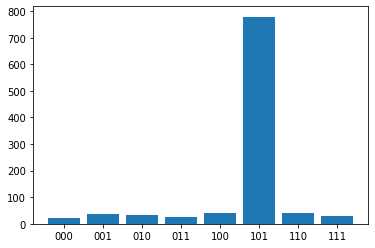

In [16]:
plot_histogram(results)

 As you can see, this is in agreement with the truth table in [section 2](http://localhost:8888/notebooks/Grover_3SAT_example.ipynb#2.-The-building-blocks-of-Grover's-algorithm:-THE-ORACLE)